In [1]:
import tensorflow as tf

In [2]:
from keras.layers import Input, Dense, Conv2D, Flatten, Lambda, Reshape, BatchNormalization, Concatenate, LeakyReLU, Dropout, Activation, UpSampling2D
from keras.models import Model
from keras import backend as K
import numpy as np


def build_encoder(input_shape, latent_dim):
    # Define the input shape
    input_shape = (96, 96, 3)

    # Define the number of latent variables
    latent_dim = 100

    # Define the encoder architecture
    input_encoder = Input(shape=input_shape, name='input_encoder')
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(input_encoder)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # Define sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    # Sample the latent space
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # Define the encoder
    encoder = Model(input_encoder, [z_mean, z_log_var, z], name='encoder')

    return encoder

In [4]:
# build the encoder and set weights with encoder50.h5
encoder = build_encoder((96, 96, 3), 100)
encoder.load_weights('vaeencoder0.h5')

In [5]:
# Define the generator
def build_decoder(latent_dim):
    # Define the noise vector input
    in_lat = tf.keras.layers.Input(shape=(latent_dim,))
    # Define the class vector input
    # in_class = tf.keras.layers.Input(shape=(num_classes,))
    # Concatenate the noise and class vectors
    # merge = tf.keras.layers.Concatenate()([in_lat, in_class])
    # Project the concatenated vector to a larger dimension
    n = 128
    size = int(96/16)
    n_nodes = n * size * size
    dense = tf.keras.layers.Dense(n_nodes)(in_lat)
    # Reshape the dense layer output
    reshaped = tf.keras.layers.Reshape((size, size, n))(dense)
    # Upsample the feature maps
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(reshaped)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    # Output layer
    out_layer = tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same')(upsampled)
    # Define the model
    model = tf.keras.models.Model(in_lat, out_layer, name='decoder')

    return model

In [6]:
# build generator and set weights with generator.h5
decoder = build_decoder(100)
decoder.load_weights('vaegenerator0.h5')


In [7]:
def build_discriminator(input_shape, latent_dim):
    # Define input layers
    img_input = Input(shape=input_shape)
    enc_input = Input(shape=(latent_dim,))

    # image branch
    img_layer = Conv2D(64, (3,3), strides=(2,2), padding='same')(img_input)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(256, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(512, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    # Flatten the features
    features = Flatten()(img_layer)

    # label branch
    latent_layer = tf.keras.layers.Dense(64)(enc_input)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(128)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(256)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(256)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Flatten()(latent_layer)

    # Concatenate the input layers
    merged_input = Concatenate()([features, latent_layer])
    merged_input = tf.keras.layers.Dropout(0.4)(merged_input)
    validity = Dense(1, activation='sigmoid')(merged_input)

    # Define the model
    model = Model(inputs=[img_input, enc_input], outputs=validity, name='discriminator')

    # compile the model
    # opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
    # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [8]:
#build discriminator and set weights with discriminator50.h5
discriminator = build_discriminator((96, 96, 3), 100)
discriminator.load_weights('vaediscriminator0.h5')

1/1 [==============================] - 7s 7s/step


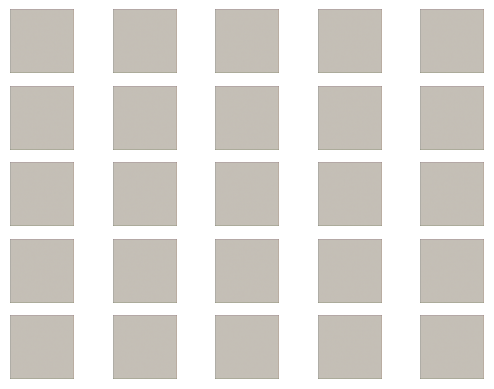

In [9]:
import matplotlib.pyplot as plt

# plot the generated image
def plot_generated(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    plt.show()

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = tf.random.normal([n_samples, latent_dim])
    return x_input

# generate images
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    return X

# generate images
latent_dim = 100
n_samples = 25
X = generate_fake_samples(decoder, latent_dim, n_samples)
# plot the result
plot_generated(X, 5)


1/1 [==============================] - 1s 500ms/step


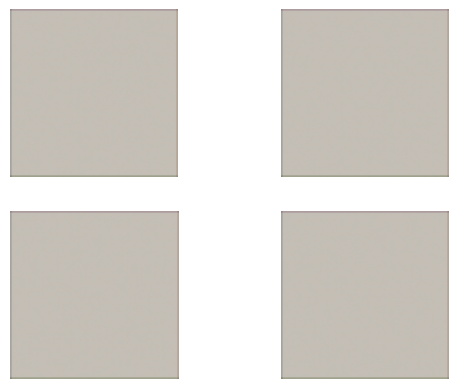

In [10]:
X = (generate_fake_samples(decoder, latent_dim, 4) * 255).astype('uint8')
# plot the result
plot_generated(X, 2)

In [15]:
test_image = tf.keras.preprocessing.image.load_img('../images/test/charmander.png', color_mode='rgba', target_size=(96, 96, 4))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = tf.expand_dims(test_image, axis=0)
import sys
sys.path.append('../')
from utils import preprocess_image
test_image = preprocess_image(test_image)
print(test_image.shape)

(1, 96, 96, 3)


In [16]:
fake_or_true = discriminator.predict([test_image, encoder.predict(test_image)[-1]])[0][0]

1/1 [==============================] - 0s 203ms/step


In [18]:
from utils import plot_image
plot_image(test_image[0], 'test_image', labels={"true:": fake_or_true}, size=96)

In [19]:
reconstruction = decoder.predict(encoder.predict(test_image)[-1])

1/1 [==============================] - 0s 381ms/step


In [22]:
plot_image(reconstruction, 'test_image', size=96)